This notebook sketches what the project would look like. Everything here runs on simulation, and so for now it replies on qiskit to convert Hamiltonian to circuit when not making approximations.

# Dependencies

In [1]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit.library import HamiltonianGate
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
import quantuminspire

# Hamiltonian

The Hamiltonian describing the collective oscillation of 2-flavored neutrinos in the flavor basis is:
$$
H = \sum_{i} \frac{\delta m^2}{4E}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V}Z_i + \sum_{j, k} \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij}) (X_j X_k + Y_jY_k + Z_jZ_k)
$$
where $V$ is the volume of the system, $N_e$ is the number of background electrons, $\theta$ the mixing angle and $\phi_{ij}$ the propagation angle between neutrino $i$ and $j$
This Hamiltonian can be rewritten in terms of pairs of neutrinos. Suppose there are $N$ neutrinos indexed $0$ to $N-1$, then the set of all pairs is $P = \{(i,j)|0 \le i < j\le N-1 \}$. The Hamiltonian is then
$$
H = \sum_{(i,j)\in P} \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_i - \cos 2\theta Z_i) + \frac{G_F N_e}{\sqrt 2 V}Z_i +  \frac{\delta m^2}{4E(N-1)}(\sin 2\theta X_j - \cos 2\theta Z_j) + \frac{G_F N_e}{\sqrt 2 V}Z_j + \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij}) (X_i X_j + Y_iY_j + Z_iZ_j)
$$

## Explanation

To understand the form of the Hamiltonian we shall start by looking at the Hamiltonian of a single neutrino in a vacuum. This neutrino's mass is an observable with eigenstates $|m_1\rangle, |m_2\rangle$. These mass eigenstates are also the energy eigenstates, which means the Hamiltonian in the mass basis is $\frac{\delta m^2}{4E}Z$ (up to a constant offset).

Just as electrons posses spin, neutrinos posses flavor. The eigenstates of flavor are $|\nu_e\rangle$ and $|\nu_\mu\rangle$ (electron and muon neutrinos). For simulation purposes we will encode them as $|\nu_e\rangle = |0\rangle$ and $|\nu_\mu\rangle = |1\rangle$.

Converting a vector in flavor basis into a vector in mass basis is done by multiplying with the matrix:
$$
\begin{bmatrix}
\cos 2\theta & -\sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix}
$$
$\theta$ is called the mixing angle because it describes how mass and flavor mix.

The vacuum Hamiltonian in flavor basis is hence (up to a global phase)
$$
\frac{\delta m^2}{4E} \begin{bmatrix}
-\cos 2\theta & \sin 2\theta\\
\sin 2\theta & \cos 2\theta
\end{bmatrix} = \frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z)
$$

The presence of electrons scatters electron neutrino, thus changing the energy for electron neutrinos. This is reflected in the Hamiltonian by adding $\frac{\sqrt 2 G_F N_e}{ V} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}$. The Hamiltonian of a neutrino in matter is thus $\frac{\delta m^2}{4E}(\sin 2\theta X - \cos 2\theta Z) + \frac{G_F N_e}{\sqrt 2 V}Z$, once again up to a constant.

Now for a pair of neutrinos, we will describe their interaction/scattering similar to the Heisenberg model, as $J(X_1X_2+Y_1Y_2+Z_1Z_2)$. The strength of interaction, $J$, should be propotional to the cosine/angular distance between the momenta of the neutrinos. Indeed, $J = \frac{\sqrt 2 G_F}{V}(1 - \cos\phi_{ij})$ where $\phi$, the propagation angle, is the angle between the momentum vectors of the two neutrinos.

And so the Hamiltonian for $N$ neutrinos is the sum Hamiltonian for each neutrino plus the interaction between every pair.

# No Approximations

In [2]:
def pauliX(i,N):
    return qp.tensor([qp.sigmax() if j == i else qp.identity(2) for j in range(N)])

def pauliY(i,N):
    return qp.tensor([qp.sigmay() if j == i else qp.identity(2) for j in range(N)])

def pauliZ(i,N):
    return qp.tensor([qp.sigmaz() if j == i else qp.identity(2) for j in range(N)])


In [3]:
def Hamiltonian(N, theta, phi, delta, E, V, Ne):
    """
    t: time
    N: number of neutrinos in system
    theta: mixing angle
    phi: a matrix of propagation angles, where phi[i,j] for i < j is the angle between ith and jth neutrino
    delta: difference of squared mass
    E: energy (in some sources E=2p)
    V: volume of system
    Ne: number of electrons
    """
    Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant'] # TODO: check if the units are consistent
    msw = Gf * Ne/(np.sqrt(2) * V)
    J = np.sqrt(2) * Gf/V
    omega = delta/(4 * E * (N-1))
    
    H = qp.tensor([0 * qp.identity(2) for i in range(N)])
    
    for i in range(N):
        for j in range(i+1,N):
            Xi = pauliX(i,N)
            Yi = pauliY(i,N)
            Zi = pauliZ(i,N)
            Xj = pauliX(j,N)
            Yj = pauliY(j,N)
            Zj = pauliZ(j,N)

            H += omega * np.sin(2 * theta) * Xi + (msw - omega * np.cos(2 * theta)) * Zi
            H += omega * np.sin(2 * theta) * Xj + (msw - omega * np.cos(2 * theta)) * Zj
            H += J * (1 - np.cos(phi[i,j]) ) * (Xi * Xj + Yi * Yj + Zi * Zj)
            
    return H

In [4]:
def ReferenceHamiltonian(N, theta, phi, delta, E, V, Ne):
    """https://arxiv.org/pdf/2102.12556.pdf"""
    H = qp.tensor([0 * qp.identity(2) for i in range(N)])
    for i in range(N):
        H += np.sqrt(1-0.925**2) * pauliX(i,N) - 0.925 * pauliZ(i,N)
    for i in range(N):
        for j in range(N):
            if i < j:
                angle = np.arccos(0.9) * np.abs(j-i)/(N-1)
                J = 1 - np.cos(angle)
                H += J * (pauliX(i,N) * pauliX(j,N) + pauliY(i,N) * pauliY(j,N) + pauliZ(i,N) * pauliZ(j,N))
    return H

In [21]:
N = 4
theta = 0.195
phi = np.array([ [np.arccos(0.9) * np.abs(i-j)/(N-1) for j in range(N)] for i in range(N)])
delta = 1
E = 0.5
V = 1e-5
Ne = 1e-4
initial_flavors = np.random.randint(2, size=N)
print(initial_flavors)


[1 0 1 1]


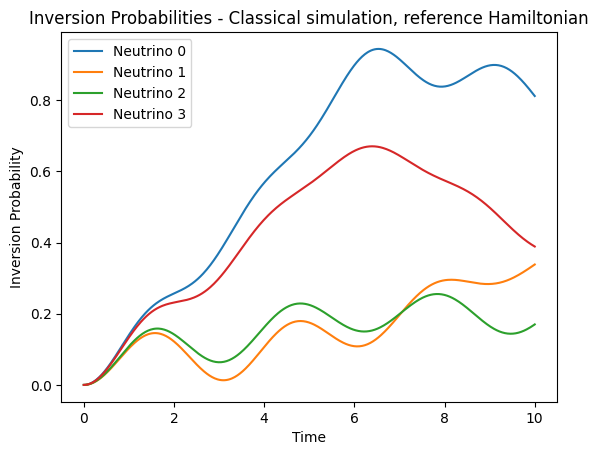

In [6]:
t_start = 0 
t_end = 10
steps = 500
H = ReferenceHamiltonian(N, theta, phi, delta, E, V, Ne)
times = np.linspace(t_start, t_end, num=steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(H, initial_state, times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
probabilities = np.zeros((N,steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]
        
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.plot(times, probabilities[qubit], label=f'Neutrino {qubit}')

plt.xlabel('Time')
plt.ylabel('Inversion Probability')
plt.title('Inversion Probabilities - Classical simulation, reference Hamiltonian')
plt.legend()
plt.show()

## Classical simulation

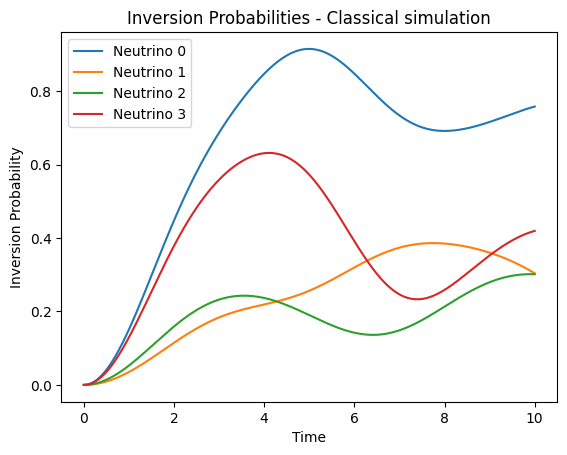

In [7]:
t_start = 0 
t_end = 10
steps = 500
H = Hamiltonian(N, theta, phi, delta, E, V, Ne)
times = np.linspace(t_start, t_end, num=steps)
initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
result = qp.mesolve(H, initial_state, times, [])
density_matrices = [qp.ket2dm(state) for state in result.states]
probabilities = np.zeros((N,steps))
for t_idx, dm in enumerate(density_matrices):
    for i in range(N):
        probabilities[i, t_idx] = dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0]
        
# Plot the probability curve for each qubit on the same graph
for qubit in range(N):
    plt.plot(times, probabilities[qubit], label=f'Neutrino {qubit}')

plt.xlabel('Time')
plt.ylabel('Inversion Probability')
plt.title('Inversion Probabilities - Classical simulation')
plt.legend()
plt.show()

## Quantum simulation no approximations

In [8]:
def inversion_probability_no_approx(start, end, steps, shots):
    ts = np.linspace(start, end, num=steps)
    # Create an array to store probabilities for each qubit at each time step
    probabilities = np.zeros((N, steps))

    for t_idx, t in enumerate(ts):
        H = Hamiltonian(N, theta, phi, delta, E, V, Ne)
        H = HamiltonianGate(H.data.toarray(), t, label='FullHamiltonian')
        circuit = QuantumCircuit(N)

        circuit.initialize("".join(map(str, reversed(initial_flavors)))) # NOTE: initialize has to be at the start, before appending gates
        circuit.append(H, range(N))
        circuit.measure_all()
        
         
        simulator = Aer.get_backend('aer_simulator')
        circ = transpile(circuit, simulator)
        result = qiskit.execute(circ, simulator, shots=shots).result()
        counts = result.get_counts()
        
        bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips

        # Iterate through the dictionary
        #print(counts)
        for bitstring, frequency in counts.items():
            # Convert the bitstring to a list of integers
            bit_list = list(map(int, bitstring)) # convert result from bitstring to list of integers
            bit_list = list(reversed(bit_list)) # reverse because little-endian?
            
            # Update the bit frequencies using the current bitstring and its frequency
            for i in range(N):
                if bit_list[i] != initial_flavors[i]:
                    bit_frequencies[i] += frequency #add to counter if flavor flips
        for i in range(N):
            probabilities[i, t_idx] = bit_frequencies[i]/shots


    # Plot the probability curve for each qubit on the same graph
    for qubit in range(N):
        plt.plot(ts, probabilities[qubit], label=f'Neutrino {qubit}')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title('Inversion Probabilities - No Approximations')
    plt.legend()
    plt.show()


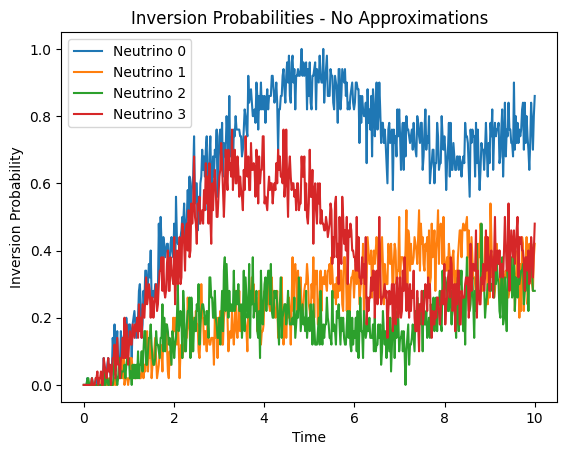

In [9]:
inversion_probability_no_approx(start=0, end=10, steps=500, shots=50)

## 1 layer of approximations

The Hamiltonian for $N$ neutrinos can be written as a sum across all pairs $H = \sum_{(i,j)\in P} H_{ij}$. If the circuit for a pair is avaliable, then the circuit for $N$ neutrinos can be approximated via Trotter decomposition $e^{-it\sum H_{ij}}\approx \prod_{(i,j)\in P} e^{-it H_{ij}}$.

In [10]:
def PairHamiltonian(N, theta, phi, delta, E, V, Ne):
    Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant'] # TODO: check if the units are consistent
    msw = Gf * Ne/(np.sqrt(2)*V)
    J = np.sqrt(2) * Gf/V * (1 - np.cos(phi)) 
    omega = delta/(4 * E * (N-1))
    
    X1 = pauliX(0,2)
    X2 = pauliX(1,2)
    Y1 = pauliY(0,2)
    Y2 = pauliY(1,2)
    Z1 = pauliZ(0,2)
    Z2 = pauliZ(1,2)
    
    H = omega * np.sin(2 * theta) * (X1 + X2) + (msw - omega * np.cos(2 * theta)) * (Z1 + Z2) + J * (X1 * X2 + Y1 * Y2 + Z1 * Z2)
    return H

In [11]:
def inversion_probability_approx(start, end, steps, shots):
    ts = np.linspace(start, end, num=steps)
    # Create an array to store probabilities for each qubit at each time step
    probabilities = np.zeros((N, steps))

    for t_idx, t in enumerate(ts):
        
        circuit = QuantumCircuit(N)
        circuit.initialize("".join(map(str, reversed(initial_flavors))))
        for i in range(N):
            for j in range(i+1,N):
                H = PairHamiltonian(N, theta, phi[i,j], delta, E, V, Ne)
                H = HamiltonianGate(H.data.toarray(), t, label=f'PairHamiltonian {i},{j}')
                circuit.append(H, [i,j])
        circuit.measure_all()
        
        simulator = Aer.get_backend('aer_simulator')
        circ = transpile(circuit, simulator)
        
        result = qiskit.execute(circ, simulator, shots=shots).result()
        counts = result.get_counts()
        
        bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit measures to 1

        # Iterate through the dictionary
        #print(counts)
        for bitstring, frequency in counts.items():
            # Convert the bitstring to a list of integers
            bit_list = list(map(int, bitstring)) # convert result from bitstring to list of integers
            bit_list = list(reversed(bit_list)) # reverse because little-endian?
            
            # Update the bit frequencies using the current bitstring and its frequency
            for i in range(N):
                if bit_list[i] != initial_flavors[i]:
                    bit_frequencies[i] += frequency #add to counter if flavor flips
        for i in range(N):
            probabilities[i, t_idx] = bit_frequencies[i]/shots


    # Plot the probability curve for each qubit on the same graph
    for qubit in range(N):
        plt.plot(ts, probabilities[qubit], label=f'Neutrino {qubit}')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title('Inversion Probabilities - Trotter')
    plt.legend()
    plt.show()


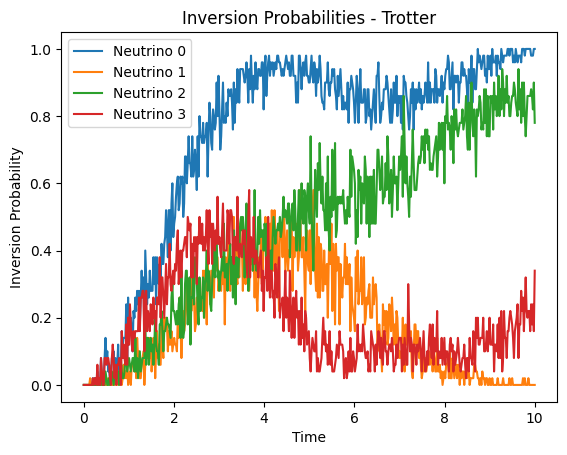

In [12]:
inversion_probability_approx(start=0, end=10, steps=500, shots=50)

# 2 layers of approximations

The Hamiltonian for $N$ neutrinos can be written as all the one-body terms plus all the two-body terms $H = \sum_i b \cdot \sigma_i + \sum_{i<j} J_{ij} \sigma_i \cdot \sigma_j$. Applying Trotter once, $U\approx e^{-it \sum_i b \cdot \sigma_i } e^{-it\sum_{i<j} J_{ij} \sigma_i \cdot \sigma_j}$. Applying Trotter again, $U\approx e^{-it \sum_i b \cdot \sigma_i } \prod_{i<j} e^{-itJ_{ij} \sigma_i \cdot \sigma_j}$

In [13]:
def OneBodyHamiltonian(N, theta, delta, E, V, Ne):
    Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant'] # TODO: check if the units are consistent
    msw = Gf * Ne/(np.sqrt(2) * V)
    omega = delta/(4 * E)
    
    H = qp.tensor([0 * qp.identity(2) for i in range(N)])
    
    for i in range(N):
            Xi = pauliX(i,N)
            Yi = pauliY(i,N)
            Zi = pauliZ(i,N)

            H += omega * np.sin(2 * theta) * Xi + (msw - omega * np.cos(2 * theta)) * Zi
            
    return H

In [14]:
def TwoBodyHamiltonian(phi, V):
    Gf, _, _ = sp.constants.physical_constants['Fermi coupling constant'] # TODO: check if the units are consistent
    J = np.sqrt(2) * Gf/V * (1 - np.cos(phi) ) 
    
    X1 = pauliX(0,2)
    X2 = pauliX(1,2)
    Y1 = pauliY(0,2)
    Y2 = pauliY(1,2)
    Z1 = pauliZ(0,2)
    Z2 = pauliZ(1,2)
    
    H = J * (X1 * X2 + Y1 * Y2 + Z1 * Z2)
    return H

In [15]:
def inversion_probability_double_approx(start, end, steps, shots):
    ts = np.linspace(start, end, num=steps)
    # Create an array to store probabilities for each qubit at each time step
    probabilities = np.zeros((N, steps))

    for t_idx, t in enumerate(ts):
        
        circuit = QuantumCircuit(N)
        circuit.initialize("".join(map(str, reversed(initial_flavors))))
        H = OneBodyHamiltonian(N, theta, delta, E, V, Ne)
        H = HamiltonianGate(H.data.toarray(), t, label='OneBodyHamiltonian')
        circuit.append(H, range(N))
        for i in range(N):
            for j in range(i+1,N):
                H = TwoBodyHamiltonian(phi[i,j], V)
                H = HamiltonianGate(H.data.toarray(), t, label=f'TwoBodyHamiltonian {i},{j}')
                circuit.append(H, [i,j])
        circuit.measure_all()
        
        simulator = Aer.get_backend('aer_simulator')
        circ = transpile(circuit, simulator)
        
        result = qiskit.execute(circ, simulator, shots=shots).result()
        counts = result.get_counts()
        
        bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit measures to 1

        # Iterate through the dictionary
        #print(counts)
        for bitstring, frequency in counts.items():
            # Convert the bitstring to a list of integers
            bit_list = list(map(int, bitstring)) # convert result from bitstring to list of integers
            bit_list = list(reversed(bit_list)) # reverse because little-endian?
            
            # Update the bit frequencies using the current bitstring and its frequency
            for i in range(N):
                if bit_list[i] != initial_flavors[i]:
                    bit_frequencies[i] += frequency #add to counter if flavor flips
        for i in range(N):
            probabilities[i, t_idx] = bit_frequencies[i]/shots


    # Plot the probability curve for each qubit on the same graph
    for qubit in range(N):
        plt.plot(ts, probabilities[qubit], label=f'Neutrino {qubit}')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title('Inversion Probabilities - Double Trotter')
    plt.legend()
    plt.show()


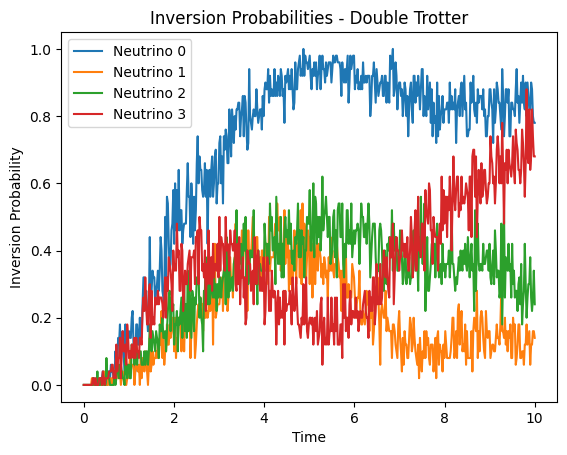

In [16]:
inversion_probability_double_approx(start=0, end=10, steps=500, shots=50)